In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics.classification import BinaryAccuracy

RANDOM_STATE = 42
BATCH_SIZE = 32
NUM_WORKERS = 4
IMG_SIZE = (224, 224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.normal(0, 0.1, size=tensor.shape)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
# Data augmentation

# ImageNet Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

std_transform = transforms.Compose([
    transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# Data augmentation taken from https://www.mdpi.com/1424-8220/20/16/4485

# TODO:randomly select multiple trials of a specific class, superimpose and normalize them
# https://ieeexplore.ieee.org/document/9450227

augmentation = transforms.Compose([
    transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    
    # Geometric Transformation
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.85, 0.95), interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=0),
    
    # Conver to tensor
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    
    # Noise Addition
    # AddGaussianNoise(0., 0.1)
])

In [4]:
# Load the datasets

train_dir = "./data/train"
test_dir = "./data/test"

train_data = datasets.ImageFolder(root=train_dir, transform=std_transform)
train_data_aug = datasets.ImageFolder(root=train_dir, transform=std_transform)

# Combine real and augmented train data
train_data = torch.utils.data.ConcatDataset([train_data, train_data_aug])

test_data = datasets.ImageFolder(root=test_dir, transform=std_transform)

len(train_data), len(test_data)

(320, 48)

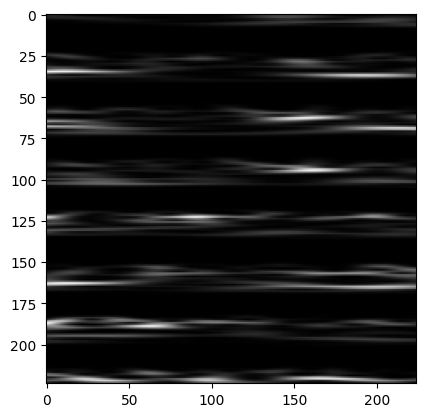

In [5]:
# display one image
sample_img, sample_label = train_data[0]

def display(img):
    # convert to NWHC since that's what matplotlib expects
    img = img.permute(1, 2, 0).numpy()

    # undo normalization
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    
display(train_data[0][0])

In [6]:
# Create dataloaders

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe930447f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe9304454e0>)

In [7]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [8]:
# Load EfficientNetV2
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights.transforms() # check image transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [10]:
# Freeze all base layers in the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# Feature Extraction (change the last layer)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # binary classifier
                    bias=True)
).to(device)

In [12]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

accuracy_fn = BinaryAccuracy().to(device)

<!-- ### Train one batch for demonstrative purposes

train_loss, train_acc = 0, 0

img_batch, label_batch = next(iter(train_dataloader))

X, y = img_batch.to(device), label_batch.to(device).float()

# Forward pass
y_logits = model(X).squeeze()
y_pred = torch.round(torch.sigmoid(y_logits))

# Calculate and accumulate loss
loss = loss_fn(y_logits, y) 
acc = accuracy_fn(y_pred, y)

train_loss += loss.item()
train_acc += acc.item()

# # Zero out gradients
# optimizer.zero_grad()

# # Backpropogate
# loss.backward()

# # Update weights
# optimizer.step()
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{y_logits}\n")
print(f"Output prediction probabilities:\n{y_pred}\n")
print(f"Actual label:\n{y}") -->

<!-- ### Test one batch for demonstrative purposes
model.eval()

test_loss, test_acc = 0, 0

with torch.inference_mode():
    # Forward pass
    test_logits = model(X).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # Caculate loss/accuracy and accumulate
    loss = loss_fn(test_logits, y)
    acc = accuracy_fn(test_pred, y)
    
    test_loss += loss.item()
    test_acc += acc.item()
    
test_loss, test_acc -->

In [14]:
# Train test loop
epochs = 10

for epoch in range(epochs):
    
    # Training
    model.train()
    
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).float()

        # Forward pass
        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Calculate loss and accuracy
        loss = loss_fn(y_logits, y) 
        acc = accuracy_fn(y_pred, y)

        # Accumulate
        train_loss += loss.item()
        train_acc += acc.item()

        # Zero out gradients
        optimizer.zero_grad()

        # Backpropogate
        loss.backward()

        # Update weights
        optimizer.step()
        

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    
    # Testing
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(test_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device).float()

            # Forward pass
            test_logits = model(X).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            # Calculate loss and accuracy
            loss = loss_fn(test_logits, y)
            acc = accuracy_fn(test_pred, y)

            # Accumulate
            test_loss += loss.item()
            test_acc += acc.item()

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    
    
    # Display train/test data for each epoch
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

Epoch: 1 | train_loss: 0.6923 | train_acc: 0.5156 | test_loss: 0.6869 | test_acc: 0.5156
Epoch: 2 | train_loss: 0.6579 | train_acc: 0.6312 | test_loss: 0.7206 | test_acc: 0.4219
Epoch: 3 | train_loss: 0.6054 | train_acc: 0.7688 | test_loss: 0.6929 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.5801 | train_acc: 0.7594 | test_loss: 0.6819 | test_acc: 0.5781
Epoch: 5 | train_loss: 0.5337 | train_acc: 0.8219 | test_loss: 0.6748 | test_acc: 0.5938
Epoch: 6 | train_loss: 0.4823 | train_acc: 0.8906 | test_loss: 0.6732 | test_acc: 0.5312
Epoch: 7 | train_loss: 0.4538 | train_acc: 0.8844 | test_loss: 0.6783 | test_acc: 0.5625
Epoch: 8 | train_loss: 0.4697 | train_acc: 0.8500 | test_loss: 0.7039 | test_acc: 0.6875
Epoch: 9 | train_loss: 0.4203 | train_acc: 0.8969 | test_loss: 0.7689 | test_acc: 0.5938
Epoch: 10 | train_loss: 0.4000 | train_acc: 0.9031 | test_loss: 0.7638 | test_acc: 0.5781
